# Missing Data EDA

- Nicolas Perez
- Conor McCormack
- Matt Yan

In [226]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline

In [227]:
df = pd.read_csv('data/prudential-life-insurance-assessment/train.csv')

## Identifiying missing values

The first thing that needs to be done is identifying which columns lack data entries. Here we construct a DataFrame containing those columns and the values for the missing data.

In [228]:
total = df.shape[0]
missing = []
names = []
percent = []
correlation = []
for i in df.columns:
    series = df[i]
    na = series.isna().sum()
    percent.append(na / total)
    names.append(series.name)
    missing.append(na)
    
missing = pd.DataFrame(list(zip(names, missing, percent)), 
               columns =['Column', 'Number of missing values', 'Percent missing'])

In [229]:
# Dropping columns with zero missing values
indexNames = missing[ missing['Number of missing values'] == 0 ].index
missing.drop(indexNames, inplace=True)
missing.set_index(missing['Column'], inplace=True)
missing.drop('Column', axis=1, inplace=True)

In [230]:
missing['Response Correlation'] = df.corr().loc[missing.index, 'Response']

## Correlation between missing data of features

We can see that there is a big correlation between the missing data in the Family History features. This indicates that there is a common root cause for the lack of data in those features

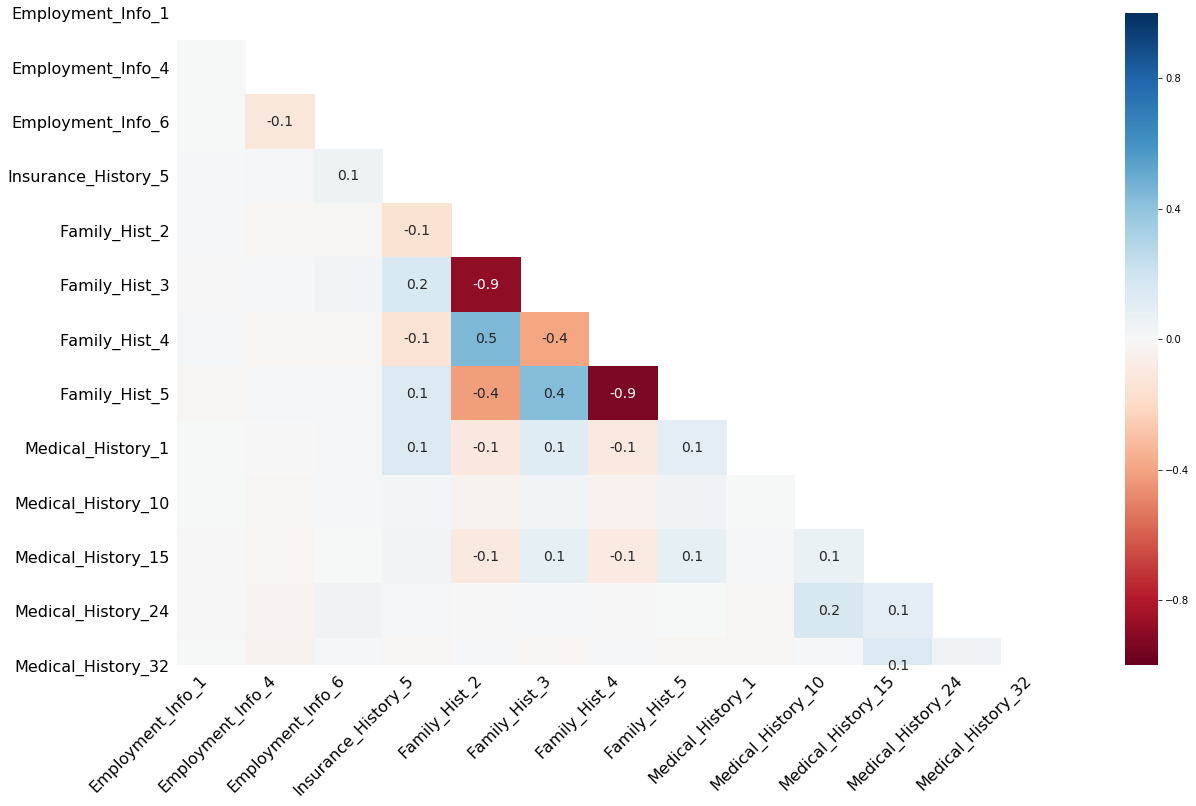

In [231]:
msno.heatmap(df)
plt.show()

## First look at missing data by feature

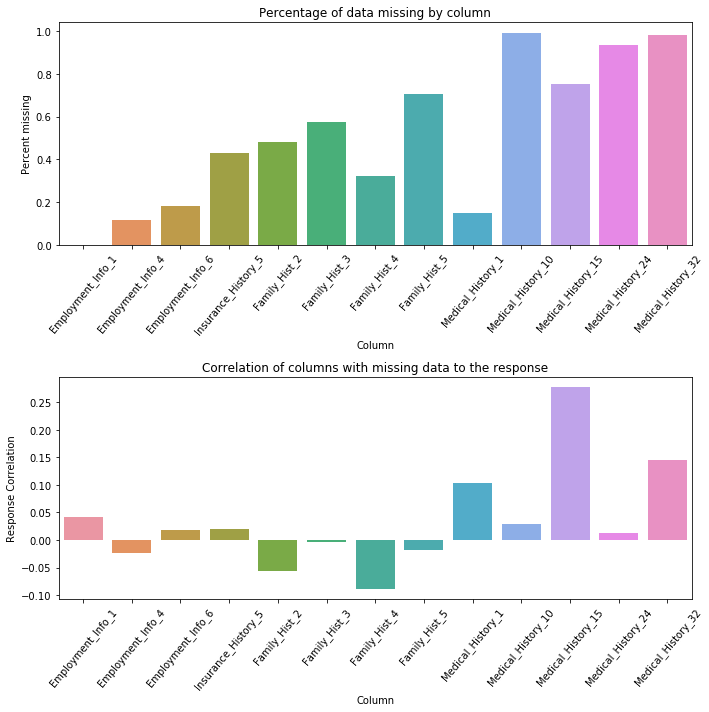

In [232]:
fig, ax = plt.subplots(ncols=2, figsize=(10,10))
# Percentage
plt.subplot(2, 1, 1)
plt.xticks(rotation=50)
plt.title('Percentage of data missing by column')
sns.barplot(x=missing.index, y=missing['Percent missing'])
# Correlation
corr = df.corr()
plt.subplot(2, 1, 2)
plt.xticks(rotation='50')
plt.title('Correlation of columns with missing data to the response')
sns.barplot(x=missing.index, y=missing['Response Correlation'])

plt.tight_layout()
plt.show()

It is immediate to notice that many of the columns that have missing data actually have no value for more than 50% of the entire set of data points. By plotting the correlation of those columns to the Response feature we can make the decision to drop the columns which have more than 60% of missing data and that correlate to the response by less than 5%.

Columns to be dropped:
- Family_Hist_5
- Medical_History_10
- Medical_History_24

In [233]:
df.drop(['Family_Hist_5', 'Medical_History_10', 'Medical_History_24'], axis=1, inplace=True)

## Missing Value Imputation

For this next phase we look at the distribution of each variable to understand their characteristics and keep to the following guidelines for inputting values to the missing data:
- Mean: used for continuous data with minimal outliers
- Median: used for continuous data with a larger number of outliers
- Mode: used for categorical data

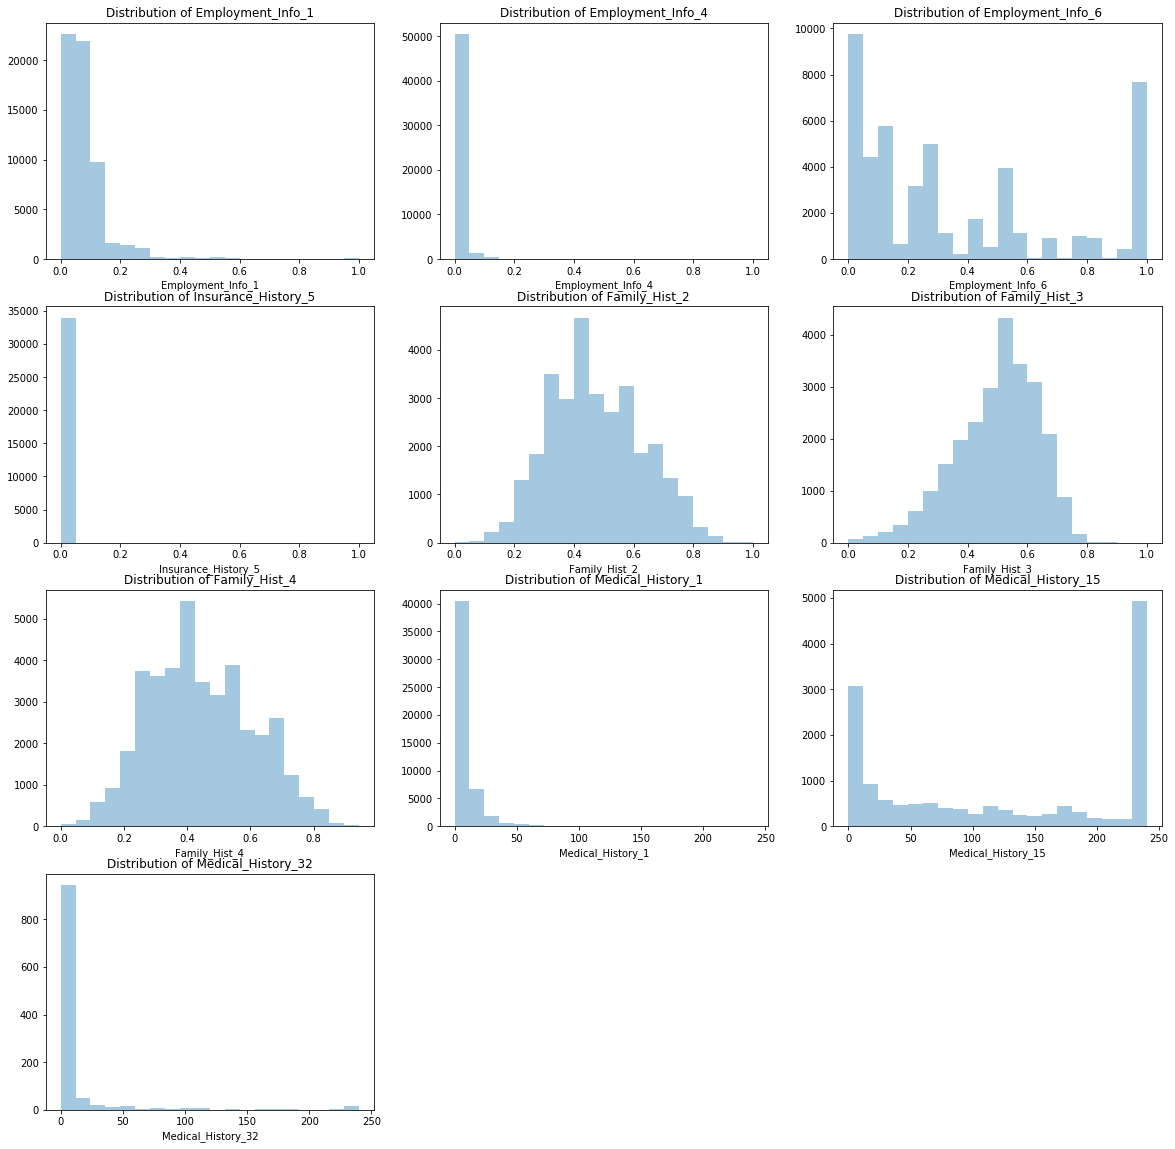

In [235]:
f, ax = plt.subplots(figsize=(20, 20))
plt.subplot(4, 3, 1)
plt.title('Distribution of Employment_Info_1')
sns.distplot(df['Employment_Info_1'].dropna(), kde=False, bins=20)
plt.subplot(4, 3, 2)
plt.title('Distribution of Employment_Info_4')
sns.distplot(df['Employment_Info_4'].dropna(), kde=False, bins=20)
plt.subplot(4, 3, 3)
plt.title('Distribution of Employment_Info_6')
sns.distplot(df['Employment_Info_6'].dropna(), kde=False, bins=20)
plt.subplot(4, 3, 4)
plt.title('Distribution of Insurance_History_5')
sns.distplot(df['Insurance_History_5'].dropna(), kde=False, bins=20)
plt.subplot(4, 3, 5)
plt.title('Distribution of Family_Hist_2')
sns.distplot(df['Family_Hist_2'].dropna(), kde=False, bins=20)
plt.subplot(4, 3, 6)
plt.title('Distribution of Family_Hist_3')
sns.distplot(df['Family_Hist_3'].dropna(), kde=False, bins=20)
plt.subplot(4, 3, 7)
plt.title('Distribution of Family_Hist_4')
sns.distplot(df['Family_Hist_4'].dropna(), kde=False, bins=20)
plt.subplot(4, 3, 8)
plt.title('Distribution of Medical_History_1')
sns.distplot(df['Medical_History_1'].dropna(), kde=False, bins=20)
plt.subplot(4, 3, 9)
plt.title('Distribution of Medical_History_15')
sns.distplot(df['Medical_History_15'].dropna(), kde=False, bins=20)
plt.subplot(4, 3, 10)
plt.title('Distribution of Medical_History_32')
sns.distplot(df['Medical_History_32'].dropna(), kde=False, bins=20)
plt.show()

### Mean Inputation

In [236]:
df['Family_Hist_2'].fillna(df['Family_Hist_2'].mean(), inplace=True)
df['Family_Hist_3'].fillna(df['Family_Hist_3'].mean(), inplace=True)
df['Family_Hist_4'].fillna(df['Family_Hist_4'].mean(), inplace=True)

### Median Inputation

In [237]:
df['Employment_Info_1'].fillna(df['Employment_Info_1'].median(), inplace=True)
df['Employment_Info_4'].fillna(df['Employment_Info_4'].median(), inplace=True)
df['Insurance_History_5'].fillna(df['Insurance_History_5'].median(), inplace=True)
df['Medical_History_1'].fillna(df['Medical_History_1'].median(), inplace=True)
df['Medical_History_32'].fillna(df['Medical_History_32'].median(), inplace=True)

### Mode Inputation

In [238]:
df['Employment_Info_6'].fillna(df['Employment_Info_6'].mode()[0], inplace=True)
df['Medical_History_15'].fillna(df['Medical_History_15'].mode()[0], inplace=True)

## Missing Data Mechanisms: *Why* is our data missing?

#### Missing Completely at Random (MCAR)
Data missing through MCAR is lost without any interpretable relationship to either observed or other missing data. Crucially, this means that the data is missing not because of any observational design errors, but due to circumstances outside the scope of data collection. In our example, this might mean that an insurance applicant simply neglected to complete a form, or some aspects of their medical history were misplaced at their care provider's offices. MCAR data is clearly unbiased. 

#### Missing at Random (MAR)
Missing data is classified as MAR when its absences can be accounted for via some relationship with the __observed__ data. This is extremely difficult to identify in large, complex, and anonymized datasets since many variables have the potential to influence data to go unrecorded and the relationship between these variables can be unclear. MAR data is also not a result of design errors in the data collection process.

In our example, this could mean that variables that doctors fail to report certain medical conditions because of biases relating to sex or race. If these biases are identified and enough relevant data is available, it would be possible to account for this missing data in our final model. 

#### Missing not at Random (MNAR)
Data scientists classify missing data as MNAR (also frequently referred to as "non-ignorable" missingness) when it is neither MCAR nor MAR. This means that neither complete randomness nor related observational biases are at fault for the missing data, but rather a fundamental flaw exists in the method of data collection itself that causes the data to go missing.

## Making sure every missing data is now gone

In [239]:
df.isna().sum().sum()

0

Articles referenced:
- https://towardsdatascience.com/handling-missing-values-in-machine-learning-part-1-dda69d4f88ca
- https://medium.com/ibm-data-science-experience/missing-data-conundrum-exploration-and-imputation-techniques-9f40abe0fd87